# Historical fixture and odds data

Fantasy Football Scout does not include fixture level data. We suspect this is likely to be predictive of performance particularly when teamed with match odds data.

In this notebook we construct the fixture and odds datasets. We also create a quick model to check whether these features are important.

## Set-up

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model, Model
from keras.layers import Dense, Flatten, LSTM, BatchNormalization, Input, Dropout, Activation, Bidirectional
from keras import initializers, optimizers

Using TensorFlow backend.


In [2]:
os.chdir('../..')

In [3]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences, \
    _load_model_from_pickle
from src.models.constants import \
    COLUMNS_TO_DROP_FOR_TRAINING
from src.models.LSTM.make_predictions import LSTMPlayerPredictor
from src.visualisation.utils import plot_learning_curve

In [4]:
pd.options.display.max_columns = None

In [5]:
RANDOM_SEED = 3
N_STEPS_IN = 5
N_STEPS_OUT = 5

## Fixture data

In [6]:
historical_fpl_data = pd.read_parquet('data/processed/fpl_data_2016_to_2019.parquet')
print(historical_fpl_data.shape)
historical_fpl_data.head()

(67834, 73)


,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,ID
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,2016-17,West Ham United,0,0,1,0,0,0,Chelsea,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,2016-17,West Ham United,0,0,1,0,0,0,Bournemouth,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,2016-17,West Ham United,0,0,1,0,0,0,Manchester City,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,2016-17,West Ham United,0,0,1,0,0,0,Watford,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,2016-17,West Ham United,0,0,1,0,0,0,West Bromwich Albion,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [7]:
(historical_fpl_data['team_name'] == historical_fpl_data['team_name_opponent']).sum()

0

In [8]:
(historical_fpl_data.duplicated()).sum()

0

In [9]:
fixtures = historical_fpl_data.copy()[['season', 'gw', 'team_name', 'team_name_opponent', 'was_home']]
fixtures.head()

,season,gw,team_name,team_name_opponent,was_home
0,2016-17,1,West Ham United,Chelsea,False
1,2016-17,2,West Ham United,Bournemouth,True
2,2016-17,3,West Ham United,Manchester City,False
3,2016-17,4,West Ham United,Watford,True
4,2016-17,5,West Ham United,West Bromwich Albion,False


In [10]:
fixtures['home_team'] = np.where(
    fixtures['was_home'],
    fixtures['team_name'],
    fixtures['team_name_opponent']
)

fixtures['away_team'] = np.where(
    fixtures['was_home'],
    fixtures['team_name_opponent'],
    fixtures['team_name']
)

In [11]:
fixtures.drop_duplicates(['season', 'home_team', 'away_team']).groupby('season').nunique()

,season,gw,team_name,team_name_opponent,was_home,home_team,away_team
season,,,,,,,
2016-17,1,38,19,19,2,20,20
2017-18,1,38,19,19,2,20,20
2018-19,1,38,19,19,2,20,20


In [12]:
fixtures.drop_duplicates(['season', 'home_team', 'away_team'], inplace=True)
fixtures.drop(columns=['team_name', 'team_name_opponent', 'was_home'], inplace=True)

print(fixtures.shape)
fixtures.head()

(1140, 4)


,season,gw,home_team,away_team
0,2016-17,1,Chelsea,West Ham United
1,2016-17,2,West Ham United,Bournemouth
2,2016-17,3,Manchester City,West Ham United
3,2016-17,4,West Ham United,Watford
4,2016-17,5,West Bromwich Albion,West Ham United


In [13]:
38*10*3

1140

In [14]:
# Highlight presence of double gameweeks
fixtures.groupby(['season', 'gw']).count()['home_team'].head(38)

season   gw
2016-17  1     10
         2     10
         3     10
         4     10
         5     10
         6     10
         7     10
         8     10
         9     10
         10    10
         11    10
         12    10
         13    10
         14    10
         15    10
         16    10
         17    10
         18    10
         19    10
         20    10
         21    10
         22    10
         23    10
         24    10
         25    10
         26     8
         27    11
         28     4
         29    10
         30    10
         31    10
         32    10
         33    10
         34    11
         35    10
         36    11
         37    15
         38    10
Name: home_team, dtype: int64

## Odds data

In [15]:
odds_data = pd.read_parquet('data/external/oddsportal_odds_2016to2019.parquet')
print(odds_data.shape)
odds_data.head()

(1140, 10)


,KO,Match,Result,1,X,2,num_available_bookmakers,home_team,away_team,season
0,14:00,Arsenal - Everton,3:1,0.36,4.63,6.94,9,Arsenal,Everton,2016-2017
1,14:00,Burnley - West Ham,1:2,1.31,2.47,2.16,9,Burnley,West Ham,2016-2017
2,14:00,Chelsea - Sunderland,5:1,0.10,9.75,24.35,9,Chelsea,Sunderland,2016-2017
3,14:00,Hull - Tottenham,1:7,8.28,5.18,0.31,9,Hull,Tottenham,2016-2017
4,14:00,Leicester - Bournemouth,1:1,0.70,3.33,3.60,9,Leicester,Bournemouth,2016-2017


In [16]:
fixtures['season'].unique()

array(['2016-17', '2017-18', '2018-19'], dtype=object)

In [17]:
odds_data['season'] = odds_data['season'].map(
    {
        '2016-2017': '2016-17', 
        '2017-2018': '2017-18', 
        '2018-2019': '2018-19'
    }
)

Correct team names in odds data

In [18]:
set(fixtures['home_team']) - set(odds_data['home_team'])

{'Brighton & Hove Albion',
 'Cardiff City',
 'Huddersfield Town',
 'Hull City',
 'Leicester City',
 'Manchester United',
 'Newcastle United',
 'Stoke City',
 'Swansea City',
 'Tottenham Hotspur',
 'West Bromwich Albion',
 'West Ham United',
 'Wolverhampton Wanderers'}

In [19]:
set(odds_data['home_team'])

{'Arsenal',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Cardiff',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Huddersfield',
 'Hull',
 'Leicester',
 'Liverpool',
 'Manchester City',
 'Manchester Utd',
 'Middlesbrough',
 'Newcastle',
 'Southampton',
 'Stoke',
 'Sunderland',
 'Swansea',
 'Tottenham',
 'Watford',
 'West Brom',
 'West Ham',
 'Wolves'}

In [20]:
odds_data_team_name_to_fpl_team_name = {
    'Hull': 'Hull City',
    'Leicester': 'Leicester City',
    'Manchester Utd': 'Manchester United',
    'Stoke': 'Stoke City',
    'Swansea': 'Swansea City',
    'Tottenham': 'Tottenham Hotspur',
    'West Brom': 'West Bromwich Albion',
    'West Ham': 'West Ham United',
    'Brighton': 'Brighton & Hove Albion',
    'Cardiff': 'Cardiff City',
    'Huddersfield': 'Huddersfield Town',
    'Newcastle': 'Newcastle United',
    'Wolves': 'Wolverhampton Wanderers'
}

In [21]:
odds_data['home_team'] = odds_data['home_team'].replace(odds_data_team_name_to_fpl_team_name)
odds_data['away_team'] = odds_data['away_team'].replace(odds_data_team_name_to_fpl_team_name)

In [22]:
set(fixtures['home_team']) - set(odds_data['home_team'])

set()

In [23]:
odds_data.head()

,KO,Match,Result,1,X,2,num_available_bookmakers,home_team,away_team,season
0,14:00,Arsenal - Everton,3:1,0.36,4.63,6.94,9,Arsenal,Everton,2016-17
1,14:00,Burnley - West Ham,1:2,1.31,2.47,2.16,9,Burnley,West Ham United,2016-17
2,14:00,Chelsea - Sunderland,5:1,0.10,9.75,24.35,9,Chelsea,Sunderland,2016-17
3,14:00,Hull - Tottenham,1:7,8.28,5.18,0.31,9,Hull City,Tottenham Hotspur,2016-17
4,14:00,Leicester - Bournemouth,1:1,0.70,3.33,3.60,9,Leicester City,Bournemouth,2016-17


In [24]:
odds_data.drop(['KO', 'Match', 'num_available_bookmakers', 'Result'], axis=1, inplace=True)

In [25]:
odds_data.rename(
    columns={
        '1': 'home_win',
        'X': 'draw',
        '2': 'away_win'
    }, 
    inplace=True
)

In [26]:
odds_data.head()

,home_win,draw,away_win,home_team,away_team,season
0,0.36,4.63,6.94,Arsenal,Everton,2016-17
1,1.31,2.47,2.16,Burnley,West Ham United,2016-17
2,0.10,9.75,24.35,Chelsea,Sunderland,2016-17
3,8.28,5.18,0.31,Hull City,Tottenham Hotspur,2016-17
4,0.70,3.33,3.60,Leicester City,Bournemouth,2016-17


In [27]:
odds_data.shape

(1140, 6)

In [28]:
odds_data.groupby('season').nunique()

,home_win,draw,away_win,home_team,away_team,season
season,,,,,,
2016-17,240,204,295,20,20,1
2017-18,240,213,290,20,20,1
2018-19,241,211,290,20,20,1


## Combine

In [29]:
fixture_and_odds = fixtures.merge(
    odds_data,
    on=['home_team', 'away_team', 'season'],
    how='inner'
)
print(fixture_and_odds.shape)
fixture_and_odds.head()

(1140, 7)


,season,gw,home_team,away_team,home_win,draw,away_win
0,2016-17,1,Chelsea,West Ham United,0.52,3.32,5.98
1,2016-17,2,West Ham United,Bournemouth,1.41,2.29,2.20
2,2016-17,3,Manchester City,West Ham United,0.27,5.42,10.92
3,2016-17,4,West Ham United,Watford,0.88,2.58,3.49
4,2016-17,5,West Bromwich Albion,West Ham United,1.82,2.21,1.74


In [30]:
fixture_and_odds.groupby('home_team').mean().sort_values('home_win')[['home_win']].head(10)

,home_win
home_team,
Manchester City,0.328070
Liverpool,0.517544
Chelsea,0.563509
Tottenham Hotspur,0.679649
Manchester United,0.751930
Arsenal,0.789298
Leicester City,1.856491
Everton,1.863860
Southampton,1.879649


Etihad is a fortress!

# Fit a model with FFS player data and fixture and odds data

## Load FFS data

In [31]:
ffs_data = pd.read_parquet('data/external/fantasy_football_scout_data_1718_to_1819.parquet')
print(ffs_data.shape)
ffs_data.head()

(20449, 49)


,Name,Team,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,position,full_name,season,gw,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,name,total_points
0,Jesus,MCI,0,1,0,0,0,0,1,0,0,78,FWD,Gabriel Fernando de Jesus,2017-2018,1,0,0.0,0,2,4,9,7.8,0,69,0.07,1.33,0,0,0,0,2,0,0,0,4,0,2,0,0,0,2,80,25,0,2,0,gabriel_fernando de jesus,1
1,Welbeck,ARS,0,0,1,3,0,0,0,0,0,75,FWD,Danny Welbeck,2017-2018,1,0,50.0,0,2,3,29,12.9,43,57,0.23,0.98,1,0,1,0,2,1,2,1,2,0,1,1,0,0,1,76,21,0,0,4,danny_welbeck,6
2,Vokes,BUR,0,0,2,2,0,0,0,0,0,90,FWD,Sam Vokes,2017-2018,1,0,70.0,2,0,1,1,10.8,65,42,0.01,0.24,0,0,2,0,0,0,0,1,0,1,0,1,0,0,4,27,15,0,1,0,sam_vokes,10
3,Vardy,LEI,0,0,2,4,0,0,0,0,0,90,FWD,Jamie Vardy,2017-2018,1,0,33.3,1,1,1,5,14.1,68,68,0.01,0.89,0,0,0,0,0,0,0,1,4,0,0,1,0,0,0,82,11,0,0,1,jamie_vardy,10
4,Sakho (Diafra),WHU,0,0,0,2,0,0,0,0,0,30,FWD,Diafra Sakho,2017-2018,1,0,60.0,1,1,0,2,0.6,0,6,0.00,0.08,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,67,6,0,1,1,diafra_sakho,1


In [32]:
ffs_data.drop(columns=['Name', 'full_name'], inplace=True)

In [33]:
ffs_data.isnull().sum().sum()

0

In [34]:
ffs_data['season'].unique()

array(['2017-2018', '2018-2019'], dtype=object)

FFS data only includes players who played > 0 minutes. Therefore if a player is benched one gameweek then they wouldn't appear in the data although we would like to train our model on these cases.

We therefore create a 'master' DataFrame of all unique names and all possible season and gameweek combinations. We then left join the FFS data and fill in nulls with zeros.

In [35]:
ffs_data_names = ffs_data[['name', 'Team', 'position']].drop_duplicates()
ffs_data_names['key'] = 1
ffs_data_names.shape

(721, 4)

In [36]:
seasons_df = pd.DataFrame({'season': ['2017-2018', '2018-2019']})
seasons_df['key'] = 1
seasons_df

,season,key
0,2017-2018,1
1,2018-2019,1


In [37]:
gw_df = pd.DataFrame({'gw': range(1, 39)})
gw_df['key'] = 1
gw_df.head()

,gw,key
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [38]:
all_season_gw_df = seasons_df.merge(gw_df, on='key')

In [39]:
all_player_season_gw_df = all_season_gw_df.merge(ffs_data_names, on='key')
all_player_season_gw_df.drop('key', axis=1, inplace=True)
all_player_season_gw_df.shape

(54796, 5)

In [40]:
ffs_data = all_player_season_gw_df.merge(ffs_data, on=['name', 'Team', 'position', 'gw', 'season'], how='left')
print(ffs_data.shape)
ffs_data.head()

(54796, 47)


,season,gw,name,Team,position,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,total_points
0,2017-2018,1,gabriel_fernando de jesus,MCI,FWD,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,78.0,0.0,0.0,0.0,2.0,4.0,9.0,7.8,0.0,69.0,0.07,1.33,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,2.0,80.0,25.0,0.0,2.0,0.0,1.0
1,2017-2018,1,danny_welbeck,ARS,FWD,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0,50.0,0.0,2.0,3.0,29.0,12.9,43.0,57.0,0.23,0.98,1.0,0.0,1.0,0.0,2.0,1.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,76.0,21.0,0.0,0.0,4.0,6.0
2,2017-2018,1,sam_vokes,BUR,FWD,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,70.0,2.0,0.0,1.0,1.0,10.8,65.0,42.0,0.01,0.24,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,27.0,15.0,0.0,1.0,0.0,10.0
3,2017-2018,1,jamie_vardy,LEI,FWD,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,33.3,1.0,1.0,1.0,5.0,14.1,68.0,68.0,0.01,0.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,82.0,11.0,0.0,0.0,1.0,10.0
4,2017-2018,1,diafra_sakho,WHU,FWD,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,60.0,1.0,1.0,0.0,2.0,0.6,0.0,6.0,0.00,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,67.0,6.0,0.0,1.0,1.0,1.0


In [41]:
ffs_data.sort_values(['name', 'season', 'gw'], inplace=True)
ffs_data.head()

,season,gw,name,Team,position,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,total_points
253,2017-2018,1,aaron_cresswell,WHU,DEF,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,1.0,1.9,0.0,18.0,0.00,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,10.0,0.0,0.0,0.0,0.0
974,2017-2018,2,aaron_cresswell,WHU,DEF,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,53.0,7.3,20.0,0.0,0.17,0.00,0.0,0.0,5.0,1.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,22.0,0.0,0.0,0.0,1.0
1695,2017-2018,3,aaron_cresswell,WHU,DEF,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,2.0,2.0,2.5,11.0,11.0,0.01,0.07,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,41.0,0.0,1.0,1.0,1.0
2416,2017-2018,4,aaron_cresswell,WHU,DEF,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,1.0,0.0,0.0,47.0,6.7,19.0,1.0,0.31,0.05,1.0,2.0,2.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,64.0,22.0,0.0,1.0,3.0,6.0
3137,2017-2018,5,aaron_cresswell,WHU,DEF,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,0.0,0.0,0.0,34.0,4.6,12.0,0.0,0.05,0.00,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,30.0,0.0,0.0,0.0,6.0


In [42]:
ffs_data.isnull().sum()

season                                  0
gw                                      0
name                                    0
Team                                    0
position                                0
Assists                             34347
Clean Sheets                        34347
Goals                               34347
Goals Conceded                      34347
Penalties Missed                    34347
Premier League Total Red Cards      34347
Premier League Yellow Cards         34347
Saves                               34347
Saves From Penalty                  34347
Time Played                         34347
Own Goals                           34347
Aerial Duels - Won - Percentage     34347
Attempts From Set Plays             34347
Big Chances Total                   34347
Chances From Open Play              34347
ICT Creativity                      34347
ICT Index                           34347
ICT Influence                       34347
ICT Threat                        

In [43]:
# From an offline check the missing entries are 0 minutes players in a given GW. We can therefore fill all missing data points with 0.
ffs_data.fillna(0, inplace=True)

In [44]:
ffs_data = pd.get_dummies(ffs_data, columns=['position'])

In [45]:
ffs_data.rename(columns={'Team': 'team_name'}, inplace=True)

### Merge fixture and odds data

Merging fixture data also serves another purpose. In the previous step we created _all_ possible gamweek-player combinations. However, due to double gameweeks there are many cases where a player simply would not feature in a given gameweek and in this case we want to remove that player-gameweek for the data. An inner join to fixtures data does this.

In [46]:
fixture_and_odds.head()

,season,gw,home_team,away_team,home_win,draw,away_win
0,2016-17,1,Chelsea,West Ham United,0.52,3.32,5.98
1,2016-17,2,West Ham United,Bournemouth,1.41,2.29,2.20
2,2016-17,3,Manchester City,West Ham United,0.27,5.42,10.92
3,2016-17,4,West Ham United,Watford,0.88,2.58,3.49
4,2016-17,5,West Bromwich Albion,West Ham United,1.82,2.21,1.74


In [47]:
# Example of gameweek with fewer than 10 games
fixture_and_odds[(fixture_and_odds['season'] == '2017-18') & (fixture_and_odds['gw'] == 31)]

,season,gw,home_team,away_team,home_win,draw,away_win
481,2017-18,31,Huddersfield Town,Crystal Palace,1.77,2.16,1.85
545,2017-18,31,Liverpool,Watford,0.18,7.51,15.76
572,2017-18,31,Bournemouth,West Bromwich Albion,0.80,2.76,3.84
608,2017-18,31,Stoke City,Everton,1.79,2.22,1.79


In [48]:
# Amend fixture data so that it is at a team level and specifies whether that team played home or away. This doubles the size of the dataset.
teams_in_gw_1 = fixture_and_odds.copy()
teams_in_gw_1['team_name'] = teams_in_gw_1['home_team']
teams_in_gw_1['team_name_opponent'] = teams_in_gw_1['away_team']
teams_in_gw_1['was_home'] = True

teams_in_gw_2 = fixture_and_odds.copy()
teams_in_gw_2['team_name'] = teams_in_gw_2['away_team']
teams_in_gw_2['team_name_opponent'] = teams_in_gw_2['home_team']
teams_in_gw_2['was_home'] = False

teams_in_gw = teams_in_gw_1.append(teams_in_gw_2)
teams_in_gw.head()

,season,gw,home_team,away_team,home_win,draw,away_win,team_name,team_name_opponent,was_home
0,2016-17,1,Chelsea,West Ham United,0.52,3.32,5.98,Chelsea,West Ham United,True
1,2016-17,2,West Ham United,Bournemouth,1.41,2.29,2.20,West Ham United,Bournemouth,True
2,2016-17,3,Manchester City,West Ham United,0.27,5.42,10.92,Manchester City,West Ham United,True
3,2016-17,4,West Ham United,Watford,0.88,2.58,3.49,West Ham United,Watford,True
4,2016-17,5,West Bromwich Albion,West Ham United,1.82,2.21,1.74,West Bromwich Albion,West Ham United,True


In [49]:
teams_in_gw['win_odds'] = np.where(
    teams_in_gw['was_home'],
    teams_in_gw['home_win'],
    teams_in_gw['away_win']
)

teams_in_gw['lose_odds'] = np.where(
    teams_in_gw['was_home'],
    teams_in_gw['away_win'],
    teams_in_gw['home_win']
)

In [50]:
teams_in_gw.drop(columns=['home_team', 'away_team', 'home_win', 'away_win'], inplace=True)

In [51]:
teams_in_gw.head()

,season,gw,draw,team_name,team_name_opponent,was_home,win_odds,lose_odds
0,2016-17,1,3.32,Chelsea,West Ham United,True,0.52,5.98
1,2016-17,2,2.29,West Ham United,Bournemouth,True,1.41,2.20
2,2016-17,3,5.42,Manchester City,West Ham United,True,0.27,10.92
3,2016-17,4,2.58,West Ham United,Watford,True,0.88,3.49
4,2016-17,5,2.21,West Bromwich Albion,West Ham United,True,1.82,1.74


In [52]:
teams_in_gw.shape

(2280, 8)

In [53]:
ffs_data['season'].replace({'2017-2018': '2017-18', '2018-2019': '2018-19'}, inplace=True)

In [54]:
ffs_data.head()

,season,gw,name,team_name,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,total_points,position_DEF,position_FWD,position_GK,position_MID
253,2017-18,1,aaron_cresswell,WHU,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,1.0,1.9,0.0,18.0,0.00,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,10.0,0.0,0.0,0.0,0.0,1,0,0,0
974,2017-18,2,aaron_cresswell,WHU,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,53.0,7.3,20.0,0.0,0.17,0.00,0.0,0.0,5.0,1.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,22.0,0.0,0.0,0.0,1.0,1,0,0,0
1695,2017-18,3,aaron_cresswell,WHU,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,2.0,2.0,2.5,11.0,11.0,0.01,0.07,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,41.0,0.0,1.0,1.0,1.0,1,0,0,0
2416,2017-18,4,aaron_cresswell,WHU,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,1.0,0.0,0.0,47.0,6.7,19.0,1.0,0.31,0.05,1.0,2.0,2.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,64.0,22.0,0.0,1.0,3.0,6.0,1,0,0,0
3137,2017-18,5,aaron_cresswell,WHU,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,0.0,0.0,0.0,34.0,4.6,12.0,0.0,0.05,0.00,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,30.0,0.0,0.0,0.0,6.0,1,0,0,0


In [55]:
ffs_team_name_to_fpl = {
    'WHU': 'West Ham United', 
    'BUR': 'Burnley', 
    'HUD': 'Huddersfield Town', 
    'ARS': 'Arsenal', 
    'CRY': 'Crystal Palace', 
    'WAT': 'Watford', 
    'FUL': 'Fulham', 
    'LIV': 'Liverpool', 
    'BOU': 'Bournemouth',
    'WOL': 'Wolverhampton Wanderers', 
    'EVE': 'Everton', 
    'LEI': 'Leicester City', 
    'WBA': 'West Bromwich Albion', 
    'NEW': 'Newcastle United', 
    'SOU': 'Southampton', 
    'MUN': 'Manchester United', 
    'SWA': 'Swansea City', 
    'BHA': 'Brighton & Hove Albion',
    'CHE': 'Chelsea',
    'CAR': 'Cardiff City',
    'MCI': 'Manchester City',
    'TOT': 'Tottenham Hotspur',
    'STK': 'Stoke City'
}

In [56]:
ffs_data['team_name'].replace(ffs_team_name_to_fpl, inplace=True)

In [57]:
ffs_data.head()

,season,gw,name,team_name,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,total_points,position_DEF,position_FWD,position_GK,position_MID
253,2017-18,1,aaron_cresswell,West Ham United,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,1.0,1.9,0.0,18.0,0.00,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,10.0,0.0,0.0,0.0,0.0,1,0,0,0
974,2017-18,2,aaron_cresswell,West Ham United,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,53.0,7.3,20.0,0.0,0.17,0.00,0.0,0.0,5.0,1.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,22.0,0.0,0.0,0.0,1.0,1,0,0,0
1695,2017-18,3,aaron_cresswell,West Ham United,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,2.0,2.0,2.5,11.0,11.0,0.01,0.07,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,41.0,0.0,1.0,1.0,1.0,1,0,0,0
2416,2017-18,4,aaron_cresswell,West Ham United,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,1.0,0.0,0.0,47.0,6.7,19.0,1.0,0.31,0.05,1.0,2.0,2.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,64.0,22.0,0.0,1.0,3.0,6.0,1,0,0,0
3137,2017-18,5,aaron_cresswell,West Ham United,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,0.0,0.0,0.0,34.0,4.6,12.0,0.0,0.05,0.00,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,30.0,0.0,0.0,0.0,6.0,1,0,0,0


In [58]:
ffs_data.shape

(54796, 50)

In [59]:
# Inner join also removes gw-season fixtures which did not happen but were filled with 0s
ffs_data = ffs_data.merge(teams_in_gw, on=['season', 'gw', 'team_name'], how='inner')
ffs_data.shape

(49020, 55)

In [173]:
# Example double gameweek
ffs_data[
    (ffs_data['team_name'] == 'Burnley') &
    (ffs_data['season'] == '2017-18') & 
    (ffs_data['gw'] == 34)
].head()

,season,gw,name,team_name,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,total_points,position_DEF,position_FWD,position_GK,position_MID,draw,team_name_opponent,was_home,win_odds,lose_odds,total_points_plus1_gw
4120,2017-18,34,aaron_lennon,Burnley,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,177.0,0.0,33.3,1.0,0.0,0.0,4.0,3.0,8.0,18.0,0.02,0.03,0.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,3.0,56.0,43.0,0.0,0.0,8.0,1.0,0,0,0,1,2.17,Leicester City,1,1.63,2.02,1.0
4121,2017-18,34,aaron_lennon,Burnley,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,177.0,0.0,33.3,1.0,0.0,0.0,4.0,3.0,8.0,18.0,0.02,0.03,0.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,3.0,56.0,43.0,0.0,0.0,8.0,1.0,0,0,0,1,2.57,Chelsea,1,3.49,0.90,2.0
4122,2017-18,34,ashley_barnes,Burnley,0.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,175.0,0.0,30.0,1.0,0.0,1.0,29.0,9.1,35.0,27.0,0.19,0.12,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,4.0,62.0,37.0,0.0,1.0,5.0,5.0,0,1,0,0,2.17,Leicester City,1,1.63,2.02,5.0
4123,2017-18,34,ashley_barnes,Burnley,0.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,175.0,0.0,30.0,1.0,0.0,1.0,29.0,9.1,35.0,27.0,0.19,0.12,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,4.0,62.0,37.0,0.0,1.0,5.0,5.0,0,1,0,0,2.57,Chelsea,1,3.49,0.90,5.0
4124,2017-18,34,ashley_roy westwood,Burnley,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,180.0,0.0,60.0,0.0,0.0,0.0,14.0,4.8,33.0,0.0,0.02,0.00,0.0,3.0,1.0,0.0,0.0,4.0,1.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,80.0,0.0,0.0,1.0,2.0,0,0,0,1,2.17,Leicester City,1,1.63,2.02,2.0


### Note:
- FFS collapses double gameweeks for players into a single row. This is why minutes played > 90.
- Our fixture and odds data is not collapsed so FFS player data is duplicated when a merge is performed.
- Need to think about how to deal with double gameweeks as this will impact the data preparation step.

### Create target

In [61]:
ffs_data['total_points_plus1_gw'] = ffs_data.groupby(['name'])['total_points'].shift(-1)
ffs_data = ffs_data[~ffs_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

In [62]:
ffs_data.head()

,season,gw,name,team_name,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,total_points,position_DEF,position_FWD,position_GK,position_MID,draw,team_name_opponent,was_home,win_odds,lose_odds,total_points_plus1_gw
0,2017-18,1,aaron_cresswell,West Ham United,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,1.0,1.9,0.0,18.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,10.0,0.0,0.0,0.0,0.0,1,0,0,0,4.57,Manchester United,False,10.59,0.31,1.0
1,2017-18,1,adrián_san miguel del castillo,West Ham United,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,4.57,Manchester United,False,10.59,0.31,0.0
2,2017-18,1,alexandre_nascimento costa silva,West Ham United,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,4.57,Manchester United,False,10.59,0.31,0.0
3,2017-18,1,andriy_yarmolenko,West Ham United,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,4.57,Manchester United,False,10.59,0.31,0.0
4,2017-18,1,andy_carroll,West Ham United,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,4.57,Manchester United,False,10.59,0.31,0.0


In [63]:
ffs_data.sort_values(['name', 'season', 'gw'], inplace=True)

### Train/dev/test split

In [66]:
ffs_data['was_home'] = ffs_data['was_home'].astype(int)

In [67]:
training_df, test_df = custom_train_test_split(ffs_data, random_state=RANDOM_SEED, rand_sample_prop=0.0027)
training_df.head()

Proportion in test set: 0.10627029934421482
Test set size: (5137, 57)
Training set size: (43202, 57)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,season,gw,name,team_name,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,total_points,position_DEF,position_FWD,position_GK,position_MID,draw,team_name_opponent,was_home,win_odds,lose_odds,total_points_plus1_gw
0,2017-18,1,aaron_cresswell,West Ham United,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,1.0,1.9,0.0,18.0,0.00,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,10.0,0.0,0.0,0.0,0.0,1,0,0,0,4.57,Manchester United,0,10.59,0.31,1.0
42,2017-18,2,aaron_cresswell,West Ham United,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,53.0,7.3,20.0,0.0,0.17,0.00,0.0,0.0,5.0,1.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,22.0,0.0,0.0,0.0,1.0,1,0,0,0,2.92,Southampton,0,4.11,0.72,1.0
84,2017-18,3,aaron_cresswell,West Ham United,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,2.0,2.0,2.5,11.0,11.0,0.01,0.07,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,41.0,0.0,1.0,1.0,1.0,1,0,0,0,2.36,Newcastle United,0,2.27,1.36,6.0
126,2017-18,4,aaron_cresswell,West Ham United,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,1.0,0.0,0.0,47.0,6.7,19.0,1.0,0.31,0.05,1.0,2.0,2.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,64.0,22.0,0.0,1.0,3.0,6.0,1,0,0,0,2.45,Huddersfield Town,1,1.06,3.00,6.0
168,2017-18,5,aaron_cresswell,West Ham United,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,0.0,0.0,0.0,34.0,4.6,12.0,0.0,0.05,0.00,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,30.0,0.0,0.0,0.0,6.0,1,0,0,0,2.26,West Bromwich Albion,0,2.42,1.33,1.0


In [68]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED, rand_sample_prop=0.003)

Proportion in test set: 0.09793528077403824
Test set size: (4231, 57)
Training set size: (38971, 57)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [69]:
print(f"Proportion training: {training_df.shape[0]/ffs_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/ffs_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/ffs_data.shape[0]}")

Proportion training: 0.8062020314859637
Proportion dev: 0.08752766916982146
Proportion test: 0.10627029934421482


### Filter out ineligible players

In [70]:
def filter_eligible_players(training_subset_df):
    training_subset_df['total_number_of_gameweeks'] = training_subset_df.groupby(['name']).transform('count')['team_name']
    training_subset_df = training_subset_df[training_subset_df['total_number_of_gameweeks'] >= (N_STEPS_IN + N_STEPS_OUT - 1)]
    training_subset_df.drop('total_number_of_gameweeks', axis=1, inplace=True)
    
    return training_subset_df

In [71]:
training_df = filter_eligible_players(training_df)
dev_df = filter_eligible_players(dev_df)
test_df = filter_eligible_players(test_df)

### Normalise features

In [72]:
COLUMNS_TO_SCALE = list(training_df.select_dtypes('number').columns.drop('total_points_plus1_gw'))
len(COLUMNS_TO_SCALE)

51

In [73]:
from sklearn.preprocessing import MinMaxScaler

In [74]:
mms = MinMaxScaler()

mms.fit(training_df[COLUMNS_TO_SCALE])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [75]:
set(training_df.columns) - set(COLUMNS_TO_SCALE)

{'name', 'season', 'team_name', 'team_name_opponent', 'total_points_plus1_gw'}

In [76]:
COLUMNS_TO_DROP_FOR_TRAINING = ['name', 'season', 'team_name', 'team_name_opponent']

### Prepare data for LSTM

In [77]:
def prepare_data_for_lstm(df):
    df = df.copy()    
    df[COLUMNS_TO_SCALE] = mms.transform(df[COLUMNS_TO_SCALE])

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df = player_df[COLUMNS_TO_SCALE + ['total_points_plus1_gw']]

        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [78]:
X_train, y_train = prepare_data_for_lstm(training_df)
X_dev, y_dev = prepare_data_for_lstm(dev_df)
X_test, y_test = prepare_data_for_lstm(test_df)

(33633, 5, 51)
(33633, 5)
(3301, 5, 51)
(3301, 5)
(4195, 5, 51)
(4195, 5)


True split after filtering:

In [79]:
total_examples = X_train.shape[0] + X_dev.shape[0] + X_test.shape[0]
print(f"Proportion training: {X_train.shape[0]/total_examples}")
print(f"Proportion dev: {X_dev.shape[0]/total_examples}")
print(f"Proportion test: {X_test.shape[0]/total_examples}")

Proportion training: 0.8177441707797418
Proportion dev: 0.08025967079189866
Proportion test: 0.10199615842835955


### Fit model

In [113]:
def create_model():
    X_input = Input(shape=(N_STEPS_IN, 51,))
    
    X = LSTM(25, return_sequences=True)(X_input)
    X = Dropout(rate=0.1)(X)
    
    X = LSTM(25, return_sequences=False)(X)
    X = Dropout(rate=0.1)(X)
    
    X = Dense(50)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)
    
    output = Dense(N_STEPS_OUT, kernel_initializer=initializers.glorot_normal())(X)
    
    model = Model(inputs=X_input, outputs=output, name='new_lstm')
    
    # Compile
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [121]:
new_lstm_model = create_model()

In [122]:
new_lstm_model.summary()

Model: "new_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 5, 51)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 5, 25)             7700      
_________________________________________________________________
dropout_17 (Dropout)         (None, 5, 25)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 25)                5100      
_________________________________________________________________
dropout_18 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                1300      
_________________________________________________________________
batch_normalization_7 (Batch (None, 50)                200

In [123]:
new_lstm_model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_dev, y_dev))

Train on 33633 samples, validate on 3301 samples
Epoch 1/100
33633/33633 [==============================] - 3s 79us/step - loss: 5.5527 - val_loss: 5.0910
Epoch 2/100
33633/33633 [==============================] - 2s 49us/step - loss: 4.2559 - val_loss: 4.0202
Epoch 3/100
33633/33633 [==============================] - 2s 49us/step - loss: 3.9280 - val_loss: 3.5492
Epoch 4/100
33633/33633 [==============================] - 2s 49us/step - loss: 3.8127 - val_loss: 3.4782
Epoch 5/100
33633/33633 [==============================] - 2s 50us/step - loss: 3.7507 - val_loss: 3.4585
Epoch 6/100
33633/33633 [==============================] - 2s 49us/step - loss: 3.7024 - val_loss: 3.4347
Epoch 7/100
33633/33633 [==============================] - 2s 50us/step - loss: 3.6790 - val_loss: 3.4066
Epoch 8/100
33633/33633 [==============================] - 2s 49us/step - loss: 3.6548 - val_loss: 3.4219
Epoch 9/100
33633/33633 [==============================] - 2s 49us/step - loss: 3.6321 - val_loss: 3.40

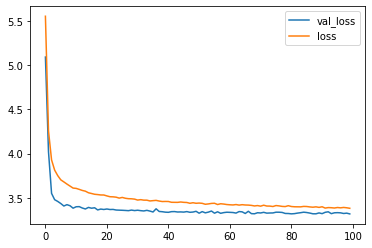

In [124]:
pd.DataFrame(new_lstm_model.history.history).plot()

Slightly odd that train performance is consistently worse than dev performance. Maybe it has more tricky cases?

In [125]:
from sklearn.metrics import mean_squared_error

In [126]:
mean_squared_error(y_dev, new_lstm_model.predict(X_dev))

3.3172533599820526

## Permutation feature importance

In [127]:
model_error = mean_squared_error(y_train, new_lstm_model.predict(X_train))

In [128]:
NUM_TRIALS = 1
pfi_dict = {}

for i, feature in enumerate(COLUMNS_TO_SCALE):
    print(feature, f'({i+1}/{len(COLUMNS_TO_SCALE)})')
    
    X_train_copy = np.copy(X_train)
    
    pfi_trials = []
    for trial in range(NUM_TRIALS):
    
        feature_array = X_train_copy[:, :, i]
        num_rows, num_cols = feature_array.shape

        shuffled_flattened = feature_array.flatten()

        np.random.shuffle(shuffled_flattened)  # shuffles in-place

        shuffled_array = shuffled_flattened.reshape(num_rows, num_cols)

        X_train_copy[:, :, i] = shuffled_array

        predictions_shuffled = new_lstm_model.predict(X_train_copy)

        model_error_perm = mean_squared_error(y_train, predictions_shuffled)

        pfi = model_error_perm / model_error

        pfi_trials.append(pfi)
        
    mean_pfi = np.mean(pfi_trials)
    std_pfi = np.std(pfi_trials)
    
    pfi_dict[feature] = {'mean': mean_pfi, 'std': std_pfi}

gw (1/51)
Assists (2/51)
Clean Sheets (3/51)
Goals (4/51)
Goals Conceded (5/51)
Penalties Missed (6/51)
Premier League Total Red Cards (7/51)
Premier League Yellow Cards (8/51)
Saves (9/51)
Saves From Penalty (10/51)
Time Played (11/51)
Own Goals (12/51)
Aerial Duels - Won - Percentage (13/51)
Attempts From Set Plays (14/51)
Big Chances Total (15/51)
Chances From Open Play (16/51)
ICT Creativity (17/51)
ICT Index (18/51)
ICT Influence (19/51)
ICT Threat (20/51)
xA Expected Assists (21/51)
xG Expected Goals (22/51)
Big Chances Created (23/51)
Blocks (24/51)
Clearances (25/51)
Crosses - Open Play - Successful (26/51)
Dribbles - Successful (27/51)
Interceptions (28/51)
Key Passes (29/51)
Net Tackles (30/51)
Recoveries (31/51)
Winning Goal (32/51)
Big Chances Missed (33/51)
Caught Offside (34/51)
Errors Leading to Chance (35/51)
Errors Leading to Goal (36/51)
Fouls Conceded (37/51)
Pass Completion (38/51)
Passes (39/51)
Penalties Conceded (40/51)
Shots Off Target (41/51)
Tackled (42/51)
to

In [129]:
pfi_df = pd.DataFrame(pfi_dict).T
pfi_df.sort_values('mean', ascending=False, inplace=True)
pfi_df

,mean,std
Time Played,1.122778,0.0
Pass Completion,1.030323,0.0
position_MID,1.015347,0.0
position_FWD,1.011606,0.0
position_DEF,1.011090,0.0
draw,1.010582,0.0
was_home,1.010547,0.0
win_odds,1.007966,0.0
Clean Sheets,1.007196,0.0
Passes,1.005818,0.0


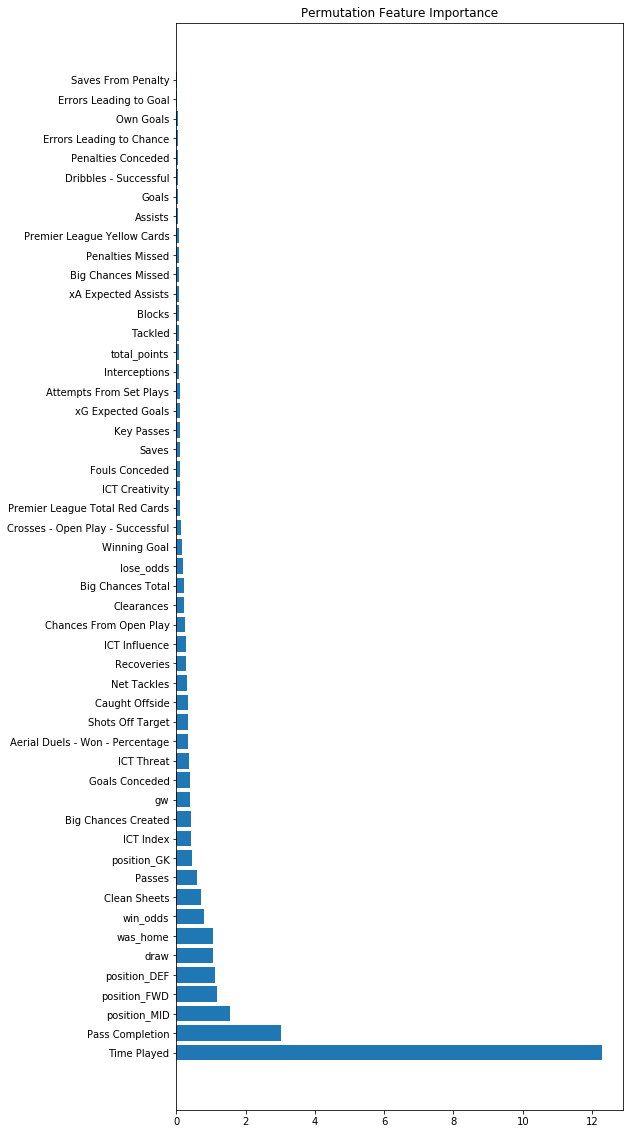

In [130]:
plt.figure(figsize=(8, 20))
plt.barh(
    pfi_df.index, 
    (pfi_df['mean'] - 1) * 100
)
plt.title('Permutation Feature Importance')
plt.show()

Time played makes sense as it is a key differentiator between 'bench warmers' and regular starters.

Pass completion again shown to be very important, caught offside less so but still high. Justifies using all available data as there may be some other surprises.

Home, win odds and draw odds also very high so justifies use of this data.

In [132]:
mean_squared_error(y_dev, new_lstm_model.predict(X_dev)) ** 0.5

1.8213328526060393

In [157]:
mean_squared_error(y_dev[:, 0], new_lstm_model.predict(X_dev)[:, 0]) ** 0.5  # Next gameweek

1.7423027826865927

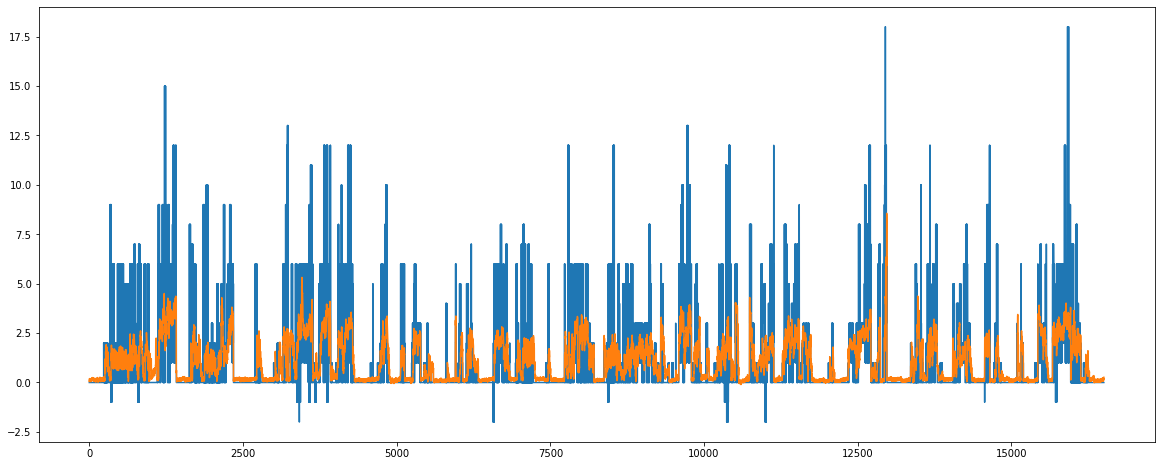

In [140]:
plt.figure(figsize=(20,8))
plt.plot(y_dev.flatten())
plt.plot(new_lstm_model.predict(X_dev).flatten())
plt.show()

In [142]:
new_lstm_model.predict(X_dev).flatten().max()

8.559635

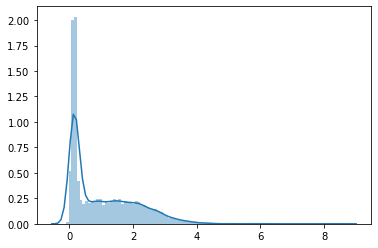

In [150]:
sns.distplot(new_lstm_model.predict(X_dev).flatten(), bins=100)
plt.show()

Signs are that model is now less conservative than the previous model.

__Conclusions__

- Odds and fixture-level data e.g. was home are predictive
- Notebook provides some of the code for generating this data
- Still need to consider how double gameweeks are dealt with given that FFS collapses these into a single row for players